In [34]:
import matplotlib.pyplot as plt
import csv
import random
import utils
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [61]:
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

In [200]:
prefix = 'GTSRB/Final_Training/Images' + '/' + format(0, '05d') + '/'
gtFile = open(prefix + 'GT-'+ format(0, '05d') + '.csv')
gtReader = csv.reader(gtFile, delimiter=';') 
next(gtReader)
gtReader

In [201]:
images = [] # images
labels = [] # corresponding labels


for row in gtReader:
    images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
    labels.append(row[7]) # the 8th column is the label
gtFile.close()

In [64]:
images, labels = readTrafficSigns('GTSRB/Final_Training/Images')

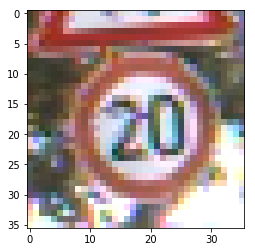

In [65]:
plt.imshow(images[42])
plt.show() 

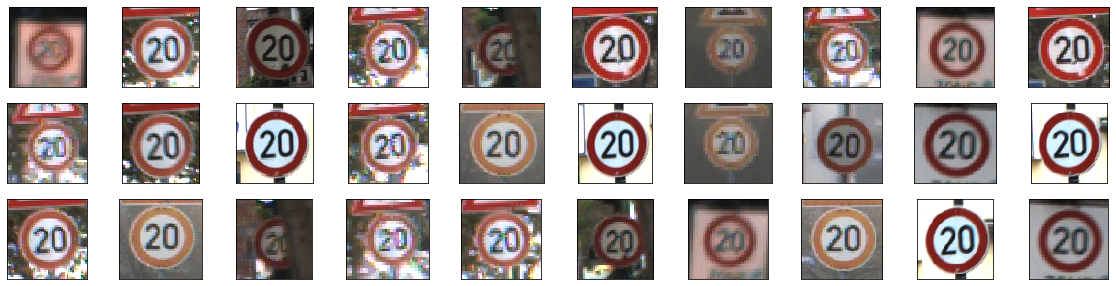

In [203]:
fig = plt.figure(figsize=(20, 5))
for i in range(30):
    ax = plt.subplot(3, 10, i + 1)
    rand_sample = random.randrange(0, len(images))
    plt.imshow(images[rand_sample], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show() 


In [ ]:
#https://chsasank.github.io/keras-tutorial.html
#https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html
#http://benchmark.ini.rub.de/?section=gtsrb&subsection=news

In [209]:
import numpy as np
from skimage import color, exposure, transform

NUM_CLASSES = 43
IMG_SIZE = 48


def preprocess_img(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img) #RGB이미지를 HSV이미지로 변환하는데 사용 
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2]) #히스토그램 균등화 후 이미지를 반환
    img = color.hsv2rgb(hsv) #HSV에서 RGB 색상 공간으로 변환 

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE)) #특정 크기와 일치하도록 이미지의 크기를 조정

    # roll color axis to axis 0
    img = np.rollaxis(img, -1)

    return img

In [ ]:
from skimage import io
import os
import glob


def get_class(img_path):
    st = img_path.split('/')[-1]
    print(st.split('\\')[-2])
    return int(st.split('\\')[-2])

root_dir = 'GTSRB/Final_Training/Images/'
imgs = []
labels = []

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    img = preprocess_img(io.imread(img_path))
    label = get_class(img_path)
    imgs.append(img)
    labels.append(label)

X = np.array(imgs, dtype='float32')
# Make one hot targets
Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]

In [231]:
X.shape

(39209, 3, 48, 48)

In [237]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [238]:
X_train.shape

(31367, 3, 48, 48)

In [239]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
K.set_image_data_format('channels_first')


def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    '''
    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    '''
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

In [240]:
from keras.optimizers import SGD

model = cnn_model()

# let's train the model using SGD + momentum
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [245]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint


def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 526 #32
epochs = 30

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[LearningRateScheduler(lr_schedule),
                     ModelCheckpoint('model.h5', save_best_only=True)]
          )

Train on 25093 samples, validate on 6274 samples
Epoch 1/30
25093/25093 [==============================] - 311s 12ms/step - loss: 0.9543 - acc: 0.7133 - val_loss: 0.4712 - val_acc: 0.8806
Epoch 2/30
25093/25093 [==============================] - 335s 13ms/step - loss: 0.5698 - acc: 0.8268 - val_loss: 0.2940 - val_acc: 0.9303
Epoch 3/30
25093/25093 [==============================] - 332s 13ms/step - loss: 0.4039 - acc: 0.8774 - val_loss: 0.2288 - val_acc: 0.9439
Epoch 4/30
25093/25093 [==============================] - 339s 14ms/step - loss: 0.3226 - acc: 0.9009 - val_loss: 0.1814 - val_acc: 0.9554
Epoch 5/30
12624/25093 [==============>...............] - ETA: 2:21 - loss: 0.2726 - acc: 0.9148

KeyboardInterrupt: 

In [256]:
X.shape

(39209, 3, 48, 48)

In [257]:
X[0].shape

(3, 48, 48)

In [258]:
X_train.shape

(31367, 3, 48, 48)

In [260]:
X_val.shape

(7842, 3, 48, 48)

In [261]:
pred = model.predict_classes(X_val)

In [275]:
y_real = []
for i in range(len(Y_val)):
    y_real.append(np.where(Y_val[i]==1)[0][0])
len(y_real)

7842

In [276]:
y_real = np.array(y_real)

In [277]:
acc = np.sum(pred == y_real) / np.size(pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9576638612598827


In [326]:
num = 103
test_img = X_val[num].reshape((-1, 3, 48, 48))
prob = model.predict_proba(test_img)
prob=prob[0]
sort_prob = prob.argsort()[::-1]
print('******** TOP 3 ********')
print('Real values:', y_real[num])
for i in sort_prob[:3]:
    print(i, prob[i])

******** TOP 3 ********
Real values: 22
22 0.9992762
25 0.0003916718
18 0.00011298601


In [337]:
# 학습과정 살펴보기
print('## training loss and acc ##')
print(model.history.history['loss'])
print(model.history.history['acc'])

## training loss and acc ##
[0.9542796317622608, 0.569828120738984, 0.4038758386505922, 0.3225641852761448]
[0.7133065006734176, 0.8268042900817589, 0.8774160092270247, 0.9009285433796058]


In [333]:
#  모델 평가하기
loss_and_metrics = model.evaluate(X_val, Y_val)
loss_and_metrics

7842/7842 [==============================] - 49s 6ms/step


In [338]:
model.save('my_model.h5')

In [340]:
from keras.models import load_model
saved_model = load_model('my_model.h5')

In [341]:
loss_and_metrics = saved_model.evaluate(X_val, Y_val)
loss_and_metrics

7842/7842 [==============================] - 48s 6ms/step


[0.16734702181005034, 0.9576638612598827]

In [ ]:
# 학습과정 살펴보기
print('## training loss and acc ##')
print(saved_model.history.history['loss'])
print(saved_model.history.history['acc'])

In [347]:
model_history = model.history.history
model_history['acc']

[0.7133065006734176,
 0.8268042900817589,
 0.8774160092270247,
 0.9009285433796058]

In [358]:
model_history

{'acc': [0.7133065006734176,
  0.8268042900817589,
  0.8774160092270247,
  0.9009285433796058],
 'loss': [0.9542796317622608,
  0.569828120738984,
  0.4038758386505922,
  0.3225641852761448],
 'lr': [0.01, 0.01, 0.01, 0.01],
 'val_acc': [0.8806184277171195,
  0.9303474702537154,
  0.9438954457987407,
  0.9553713686419856],
 'val_loss': [0.47121185240070645,
  0.29402466320691306,
  0.22878271524678911,
  0.18136657979654058]}

In [ ]:
# 모델 히스토리 저장/로드

In [365]:
with open('model_history.p', 'wb') as fp:
    pickle.dump(model_history, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [366]:
with open('model_history.p', 'rb') as fp:
    model_hist = pickle.load(fp) 

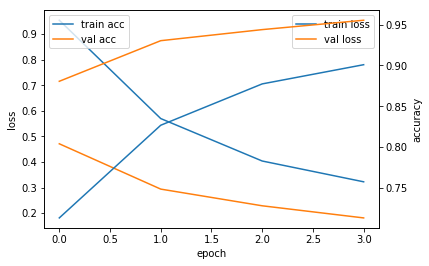

In [353]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(model_history['loss'], label='train loss')
loss_ax.plot(model_history['val_loss'], label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')

acc_ax.plot(model_history['acc'], label='train acc')
acc_ax.plot(model_history['val_acc'], label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='best')

plt.show()